<a href="https://colab.research.google.com/github/saspav/Deep-Learning-2022/blob/main/14_1_simpsons_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# !pip install -U torch torchvision

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device(("cpu", "cuda")[train_on_gpu])
DEVICE

CUDA is available!  Training on GPU ...


device(type='cuda')

In [2]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
print(PIL.__version__)
# здесь должна быть версия 5.3.0. если это не так перегрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

7.1.2


In [ ]:
# ! pip install kaggle

In [3]:
# перед запуском этого нужно положить kaggle.json в корень сессионного хранилища

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download journey-springfield
!unzip -q -o journey-springfield.zip

 99% 518M/521M [00:13<00:00, 42.2MB/s]
100% 521M/521M [00:13<00:00, 41.0MB/s]


In [4]:
!nvidia-smi

torch.cuda.is_available()

Tue Nov 15 11:54:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [5]:
import random
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import Counter

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
__import__('warnings').filterwarnings("ignore")

seed = 2022
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = self.transform

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, 
                                          stratify=train_val_labels, 
                                          random_state=seed)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# # uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

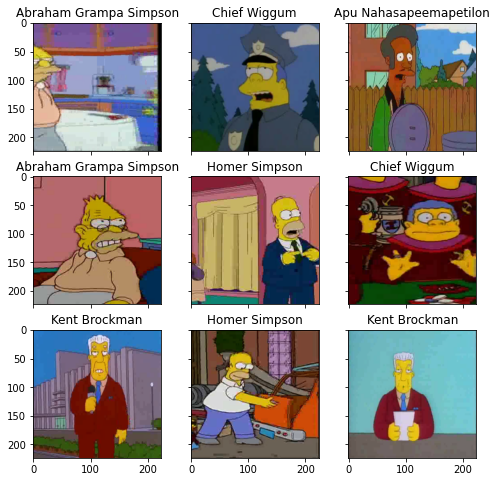

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [12]:
# Уже не Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, n_classes),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(model, opt, scheduler, epochs, batch_size, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = .0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, 
                                              opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, 
                                           v_acc=val_acc))

    print('Best val Acc: {:4f}'.format(best_acc))
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)

    return history, model

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
optimizer = torch.optim.Adam(simple_cnn.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
history, model_cnn = train(simple_cnn, optimizer, scheduler, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.9230244895304405


epoch:   7%|▋         | 1/15 [02:42<37:49, 162.10s/it]


Epoch 001 train_loss: 1.9230     val_loss 1.3275 train_acc 0.5027 val_acc 0.6360
loss 1.072047091718755


epoch:  13%|█▎        | 2/15 [05:21<34:49, 160.73s/it]


Epoch 002 train_loss: 1.0720     val_loss 0.7589 train_acc 0.7008 val_acc 0.7946
loss 0.6888281525722183


epoch:  20%|██        | 3/15 [08:00<31:58, 159.91s/it]


Epoch 003 train_loss: 0.6888     val_loss 0.5629 train_acc 0.8029 val_acc 0.8572
loss 0.2524703320971441


epoch:  27%|██▋       | 4/15 [10:39<29:15, 159.61s/it]


Epoch 004 train_loss: 0.2525     val_loss 0.3581 train_acc 0.9269 val_acc 0.9114
loss 0.12067464557872076


epoch:  33%|███▎      | 5/15 [13:18<26:30, 159.06s/it]


Epoch 005 train_loss: 0.1207     val_loss 0.3466 train_acc 0.9661 val_acc 0.9233
loss 0.050177496267330673


epoch:  40%|████      | 6/15 [15:56<23:50, 158.93s/it]


Epoch 006 train_loss: 0.0502     val_loss 0.3648 train_acc 0.9876 val_acc 0.9260
loss 0.01488511394747167


epoch:  47%|████▋     | 7/15 [18:34<21:08, 158.56s/it]


Epoch 007 train_loss: 0.0149     val_loss 0.3507 train_acc 0.9980 val_acc 0.9381
loss 0.005545409457294657


epoch:  53%|█████▎    | 8/15 [21:13<18:29, 158.57s/it]


Epoch 008 train_loss: 0.0055     val_loss 0.3711 train_acc 0.9995 val_acc 0.9367
loss 0.004534755987668392


epoch:  60%|██████    | 9/15 [23:51<15:50, 158.49s/it]


Epoch 009 train_loss: 0.0045     val_loss 0.3835 train_acc 0.9995 val_acc 0.9381
loss 0.002853586248882628


epoch:  67%|██████▋   | 10/15 [26:29<13:12, 158.43s/it]


Epoch 010 train_loss: 0.0029     val_loss 0.3890 train_acc 0.9997 val_acc 0.9374
loss 0.0021035510768781292


epoch:  73%|███████▎  | 11/15 [29:08<10:33, 158.43s/it]


Epoch 011 train_loss: 0.0021     val_loss 0.3952 train_acc 0.9999 val_acc 0.9377
loss 0.0018358067147391441


epoch:  80%|████████  | 12/15 [31:47<07:55, 158.65s/it]


Epoch 012 train_loss: 0.0018     val_loss 0.4004 train_acc 0.9999 val_acc 0.9377
loss 0.001637052276487738


epoch:  87%|████████▋ | 13/15 [34:26<05:17, 158.71s/it]


Epoch 013 train_loss: 0.0016     val_loss 0.4022 train_acc 0.9999 val_acc 0.9379
loss 0.001538272424534941


epoch:  93%|█████████▎| 14/15 [37:04<02:38, 158.62s/it]


Epoch 014 train_loss: 0.0015     val_loss 0.4045 train_acc 0.9999 val_acc 0.9374
loss 0.001475699265497058


epoch: 100%|██████████| 15/15 [39:43<00:00, 158.87s/it]


Epoch 015 train_loss: 0.0015     val_loss 0.4064 train_acc 0.9999 val_acc 0.9374
Best val Acc: 0.938142


Построим кривые обучения

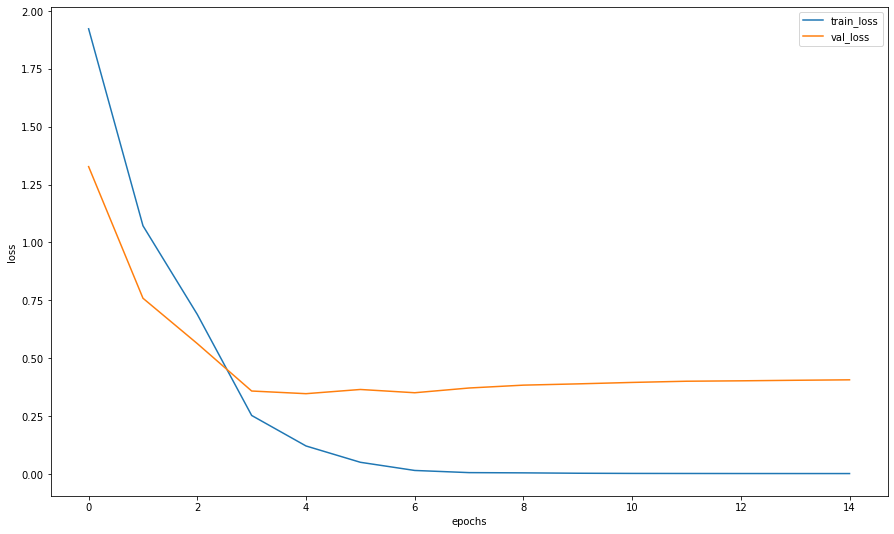

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [40]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
len(actual_labels), actual_labels

(20, [6, 6, 6, 7, 4, 4, 4, 5, 7, 0, 6, 2, 2, 6, 0, 4, 7, 4, 2, 4])

In [ ]:
len(y_pred), y_pred

(20, array([ 6,  6,  6,  7, 20, 15,  4,  5,  7, 15, 15,  2, 28,  6,  0,  4,  7,
         4,  2,  4]))

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

0.848888888888889

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

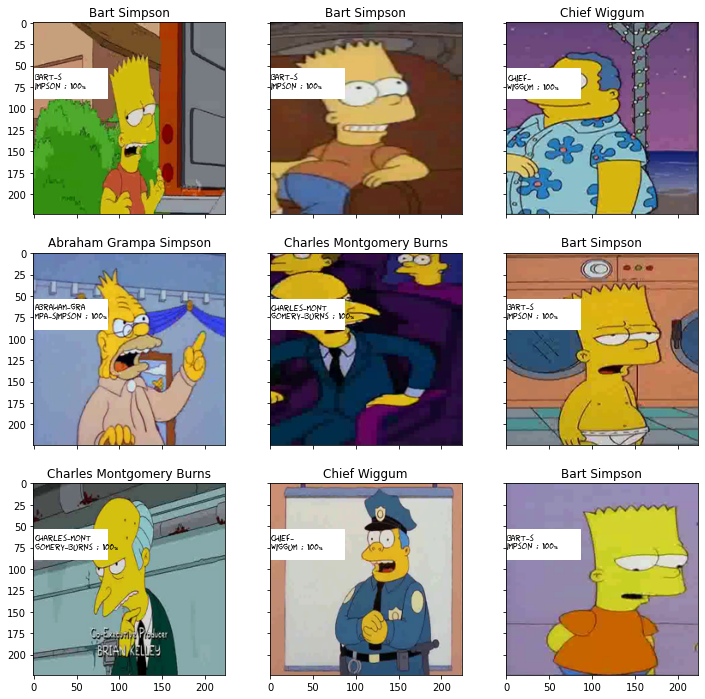

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла распознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
make_submit = True
if make_submit:
  my_submit.to_csv('simple_cnn_baseline.csv', index=False)

  !kaggle competitions submit -c journey-springfield -f simple_cnn_baseline.csv -m "simple_cnn_baseline"

100% 25.8k/25.8k [00:02<00:00, 10.2kB/s]
Successfully submitted to Journey to Springfield

Модифицированный simple_cnn выдал результат на Каггле: 0.98831

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочных улучшений для нашей сети, которые наверняка пришли Вам в голову: 

*  Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*  Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

In [19]:
# посмотрим на распределение изображений по классам
tv_labels = pd.Series(train_val_labels).value_counts().sort_values().to_frame("counts")
tv_labels

,counts
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Очень сильно разбалансированы классы, проблемой займемся чуть позже

In [20]:
# Аугментация 

augmentations = transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomResizedCrop(224 ,scale=(0.7, 1)),
])

aug_transform = transforms.Compose([                                    
    augmentations,
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                    
])

In [21]:
# full_train_dataset = SimpsonsDataset(train_val_files, mode='train')
# aug_train_dataset = SimpsonsDataset(train_val_files, mode='train', transform=aug_transform)
# train_dataset = ConcatDataset([full_train_dataset, aug_train_dataset])
train_dataset = SimpsonsDataset(train_val_files, mode='train')

In [22]:
# балансировка классов
class_counts = Counter(map(lambda x: train_dataset.label_encoder.transform([x]).item(), train_dataset.labels))
class_weights = {name: 1/cnt for name, cnt in class_counts.items()}

In [23]:
sample_weights = [0] * len(train_dataset)
for idx, (_, label) in enumerate(tqdm(train_dataset)):
    sample_weights[idx] = class_weights[label]

100%|██████████| 20933/20933 [02:18<00:00, 150.95it/s]


In [26]:
num_samples = max(class_counts.values()) * len(class_counts)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
# train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)

In [ ]:
# попробуем обучить сеть после балансировки классов
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, lr=1e-4, betas=(0.9, 0.999))
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
history, model_cnn = train(simple_cnn, optimizer, scheduler, epochs=9, batch_size=128, sampler=train_sampler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.24754011950917462


epoch:   7%|▋         | 1/15 [02:53<40:34, 173.91s/it]


Epoch 001 train_loss: 0.2475     val_loss 0.1685 train_acc 0.9345 val_acc 0.9506
loss 0.14429536059492382


epoch:  13%|█▎        | 2/15 [05:47<37:36, 173.60s/it]


Epoch 002 train_loss: 0.1443     val_loss 0.1627 train_acc 0.9548 val_acc 0.9487
loss 0.1223987157296455


epoch:  20%|██        | 3/15 [08:34<34:06, 170.55s/it]


Epoch 003 train_loss: 0.1224     val_loss 0.0984 train_acc 0.9616 val_acc 0.9704
loss 0.019484366882063536


epoch:  27%|██▋       | 4/15 [11:19<30:54, 168.57s/it]


Epoch 004 train_loss: 0.0195     val_loss 0.0022 train_acc 0.9946 val_acc 0.9998
loss 0.002118150317316224


epoch:  33%|███▎      | 5/15 [14:06<27:57, 167.75s/it]


Epoch 005 train_loss: 0.0021     val_loss 0.0012 train_acc 0.9996 val_acc 0.9995
loss 0.0022441537561133187


epoch:  40%|████      | 6/15 [16:51<25:03, 167.09s/it]


Epoch 006 train_loss: 0.0022     val_loss 0.0007 train_acc 0.9995 val_acc 0.9998
loss 0.0008702692019557166


epoch:  47%|████▋     | 7/15 [19:36<22:11, 166.41s/it]


Epoch 007 train_loss: 0.0009     val_loss 0.0005 train_acc 0.9998 val_acc 1.0000
loss 0.0005138818431799603


epoch:  53%|█████▎    | 8/15 [22:24<19:28, 166.91s/it]


Epoch 008 train_loss: 0.0005     val_loss 0.0005 train_acc 0.9998 val_acc 1.0000
loss 0.00041614816232012194


epoch:  60%|██████    | 9/15 [25:12<16:43, 167.30s/it]


Epoch 009 train_loss: 0.0004     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
loss 0.0003363778687701307


epoch:  67%|██████▋   | 10/15 [28:01<13:57, 167.55s/it]


Epoch 010 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
loss 0.0003266763995836546


epoch:  73%|███████▎  | 11/15 [30:47<11:09, 167.26s/it]


Epoch 011 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9998 val_acc 0.9998
loss 0.00031656356575778346


epoch:  80%|████████  | 12/15 [33:34<08:20, 166.97s/it]


Epoch 012 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
loss 0.0002987097219126411


epoch:  87%|████████▋ | 13/15 [36:23<05:35, 167.85s/it]


Epoch 013 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
loss 0.00029681548616267373


epoch:  93%|█████████▎| 14/15 [39:15<02:48, 168.86s/it]


Epoch 014 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
loss 0.0002926238436282221


epoch: 100%|██████████| 15/15 [42:13<00:00, 168.93s/it]


Epoch 015 train_loss: 0.0003     val_loss 0.0004 train_acc 0.9999 val_acc 0.9998
Best val Acc: 1.000000


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [ ]:
make_submit = True
if make_submit:
  my_submit.to_csv('cnn_augment.csv', index=False)

  !kaggle competitions submit -c journey-springfield -f cnn_augment.csv -m "cnn_augment_balansed"

Модифицированный simple_cnn c балансировкой классов выдал результат на Каггле: 0.99893

### Попробуем предобученную модель resnet18

In [24]:
from torchvision import models

In [27]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [28]:
train_counts = 0
for _, labels in tqdm(train_loader):
    train_counts += len(labels)

100%|██████████| 737/737 [09:58<00:00,  1.23it/s]

94332


In [30]:
# train_counts = 94332

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_counts, 'val': len(val_dataset)}
class_names = [*class_weights.keys()]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

In [32]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
            pbar_outer.update(1)
            # tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc)) 

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [35]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [36]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 42)
model_conv.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, n_classes),
        )    

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [37]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 3.4666 Acc: 0.1636


epoch:   7%|▋         | 1/15 [13:32<3:09:30, 812.14s/it]

val Loss: 3.1856 Acc: 0.3141
Epoch 1/14
----------
train Loss: 2.3833 Acc: 0.4283


epoch:  13%|█▎        | 2/15 [25:55<2:47:11, 771.65s/it]

val Loss: 2.0470 Acc: 0.5216
Epoch 2/14
----------
train Loss: 1.5740 Acc: 0.6002


epoch:  20%|██        | 3/15 [38:07<2:30:41, 753.43s/it]

val Loss: 1.5830 Acc: 0.5897
Epoch 3/14
----------
train Loss: 1.3211 Acc: 0.6605


epoch:  27%|██▋       | 4/15 [50:13<2:16:08, 742.60s/it]

val Loss: 1.4831 Acc: 0.6246
Epoch 4/14
----------
train Loss: 1.2895 Acc: 0.6668


epoch:  33%|███▎      | 5/15 [1:02:22<2:02:58, 737.89s/it]

val Loss: 1.4446 Acc: 0.6334
Epoch 5/14
----------
train Loss: 1.2579 Acc: 0.6735


epoch:  40%|████      | 6/15 [1:14:40<1:50:40, 737.86s/it]

val Loss: 1.4364 Acc: 0.6298
Epoch 6/14
----------
train Loss: 1.2437 Acc: 0.6765


epoch:  47%|████▋     | 7/15 [1:26:52<1:38:06, 735.80s/it]

val Loss: 1.4277 Acc: 0.6351
Epoch 7/14
----------
train Loss: 1.2382 Acc: 0.6804


epoch:  53%|█████▎    | 8/15 [1:38:51<1:25:14, 730.61s/it]

val Loss: 1.4202 Acc: 0.6363
Epoch 8/14
----------
train Loss: 1.2386 Acc: 0.6792


epoch:  60%|██████    | 9/15 [1:50:52<1:12:45, 727.54s/it]

val Loss: 1.4104 Acc: 0.6358
Epoch 9/14
----------
train Loss: 1.2313 Acc: 0.6801


epoch:  67%|██████▋   | 10/15 [2:02:57<1:00:33, 726.64s/it]

val Loss: 1.4216 Acc: 0.6372
Epoch 10/14
----------
train Loss: 1.2356 Acc: 0.6782


epoch:  73%|███████▎  | 11/15 [2:15:02<48:24, 726.14s/it]  

val Loss: 1.4096 Acc: 0.6396
Epoch 11/14
----------
train Loss: 1.2337 Acc: 0.6779


epoch:  80%|████████  | 12/15 [2:27:00<36:11, 723.92s/it]

val Loss: 1.4082 Acc: 0.6367
Epoch 12/14
----------
train Loss: 1.2390 Acc: 0.6778


epoch:  87%|████████▋ | 13/15 [2:39:04<24:07, 723.73s/it]

val Loss: 1.4234 Acc: 0.6322
Epoch 13/14
----------
train Loss: 1.2360 Acc: 0.6767


epoch:  93%|█████████▎| 14/15 [2:51:19<12:07, 727.32s/it]

val Loss: 1.4131 Acc: 0.6360
Epoch 14/14
----------
train Loss: 1.2320 Acc: 0.6806


epoch: 100%|██████████| 15/15 [3:03:23<00:00, 733.55s/it]

val Loss: 1.4178 Acc: 0.6332
Training complete in 183m 23s
Best val Acc: 0.639599


In [38]:
torch.save(model_conv, 'model_conv.pt')

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_conv, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [43]:
my_submit.to_csv('resnet18.csv', index=False)

make_submit = True
if make_submit:
  !kaggle competitions submit -c journey-springfield -f resnet18.csv -m "resnet18"

100% 26.0k/26.0k [00:00<00:00, 45.3kB/s]
Successfully submitted to Journey to Springfield

resnet18 выдал результат на Каггле:0.62166